# 트랜스포머로 만드는 대화형 챗봇

## 목표

- 1) 트랜스포머의 인코더, 디코더 구조 이해하기
- 2) 내부 단어 토크나이저 사용하기
- 3) 셀프 어텐션 이해하기
- 4)  한국어에도 적용해보기

In [3]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import Image

img_path = os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E15_chatbot/data/images'

## 1. 트랜스포머와 인코더-디코더

- 최근 BERT 등의 pretrained model의 발전으로 새로운 기대를 받고 있다.
- BERT, ALBERT 등은 모두 트랜스포머(Transformer) 모델을 활용해 pretrain을 적용한 것들이다.
- 2017년에 발표된 트랜스포머는 병렬처리에 불리한 LSTM에 비해 훨씬 뛰어난 처리 속도를 보이면서도 LSTM 등 RNN 모델이 가지는 장기 의존성에 강건한 특징 때문에 매우 긴 길이의 문장을 처리하는 데 유리하다.


#### - 인코더와 디코더 구조

- 인코더에는 입력 문장이, 디코더는 이에 상응하는 출력 문장을 생성한다.
- 결국 입력과 출력 문장 두 가지 병렬 구조로 구성된 데이터셋을 훈련해야 한다.

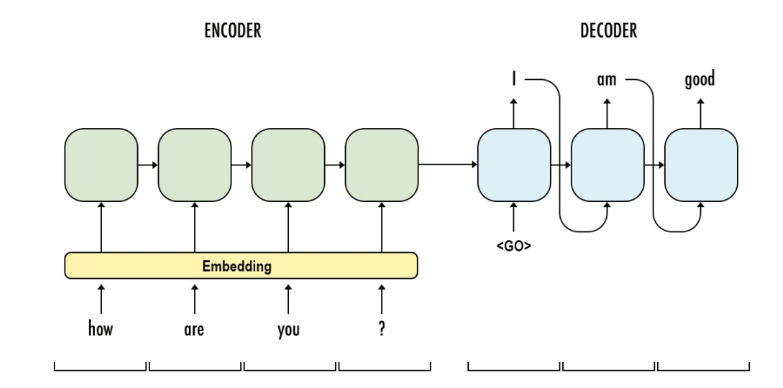

In [8]:
Image(img_path + '/1.png')

#### - 트랜스포머의 인코더와 디코더

- 초록색 색깔의 도형을 인코더 layer, 핑크색 도형을 디코더 layer라고 할 때,
- 입력 문장은 누적해 쌓아 올린 인코더 레이어를 통해 정보를 뽑아 내고,
- 디코더는 누적해 쌓아 올린 디코더 레이어를 통해서 출력 문장의 단어를 하나씩 만들어가는 구조이다.
- 인코더와 디코더를 각각 확대해보면, 톱니바퀴처럼 맞물려 돌아가는 여러 부품들로 구성돼 있다.

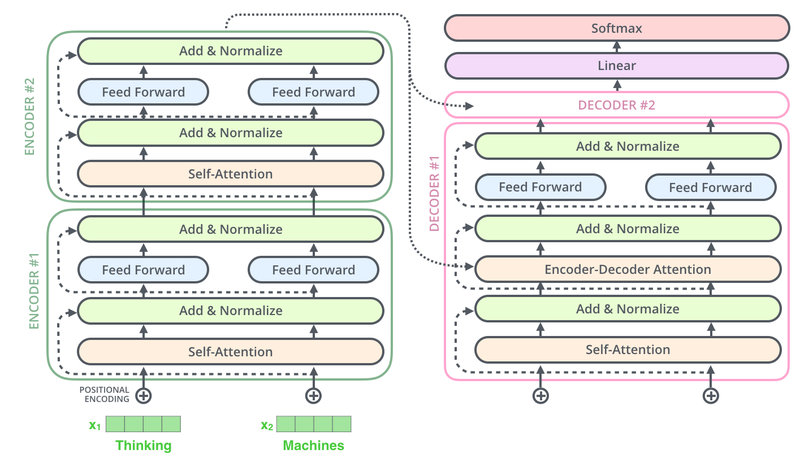

In [9]:
Image(img_path + '/2.png')

- 트랜스포머 모델의 입력 데이터 처리에서 RNN 계열 모델들과 다른 점은 바로 임베딩 벡터에 positional encoding 값을 더한 후 입력으로 사용한다는 점이다.
- 이렇게 하는 이유는 트랜스포머는 입력을 받을 때, 문장의 단어들을 1개씩 순차적으로 받는 게 아니라, 모든 단어를 한꺼번에 입력 받기 때문이다.

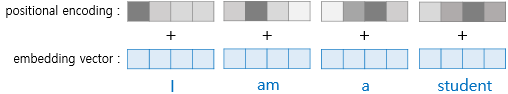

In [10]:
Image(img_path + '/3.png')

- positional encoding의 벡터 값은 아래 수식으로 정해진다.
- 사인, 코사인 함수 값을 더함으로써 단어의 순서 정보를 더해주는 것이다.
- 이때 임베딩 벡터와 포지셔널 인코딩의 덧셈은 임베딩 벡터가 모여 만들어진 문장 벡터 행렬과 포지셔널 인코딩 행렬의 덧셈 연산으로 이루어진다.

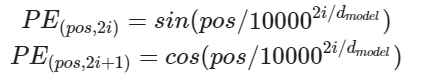

In [11]:
Image(img_path + '/4.png')

- $d_{model}$은 임베딩 벡터의 차원을, $pos$는 입력 문장에서 임베딩 벡터의 위치를, $i$는 임베딩 벡터 내의 차원의 인덱스를 의미한다.
- 각 행렬을 더함으로써 단어 벡터에 위치 정보를 더해주는 것!

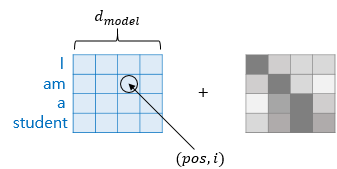

In [12]:
Image(img_path + '/5.png')

In [8]:
# 포지셔널 인코딩 레이어 구현하기
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i//2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
        
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

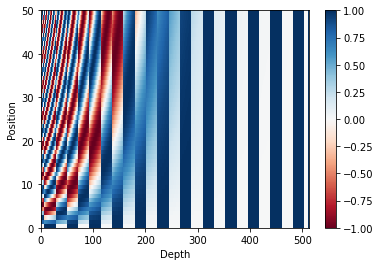

In [17]:
# 행의 크기가 50, 열의 크기가 512인 행렬
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 2. 어텐션

- 어텐션 메커니즘을 그림으로 표현하면 아래와 같다.
- 어텐션 함수는 주어진 쿼리에 대해 모든 키(key)와의 유사도를 각각 구한다.
- 그리고 이 유사도를 키와 맵핑되어 있는 각각의 값(value)에 반영한다.
- 그 값을 모두 더해서 뭉쳐주면 최종 어텐션 값을 얻는다.

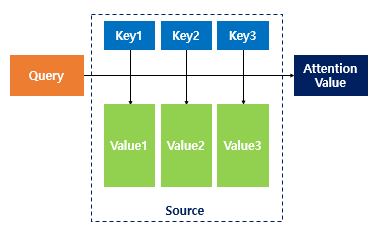

In [18]:
Image(img_path + '/6.png')

#### - 트랜스포머에서 사용된 어텐션

- 트랜스포머는 총 3 가지의 어텐션을 사용한다.
- 1) Encoder Self-Attention은 인코더에서,
- 2) Masked Decoder Self-Attention은 디코더에서,
- 3) Encoder-Decoder Attention도 디코더에서 사용된다.

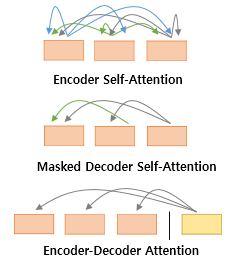

In [19]:
Image(img_path + '/7.png')

- 아래 그림은 트랜스포머의 전체적인 아키텍처에서 각 어텐션이 위치한 곳을 보여준다.
- 트랜스포머의 어텐션 함수에서 사용되는 쿼리, key, value는 기본적으로 단어 벡터이다.
- 이때 단어 벡터란 초기 입력으로 사용되었던 임베딩 벡터가 아닌, 트랜스포머의 여러 연산을 거친 후의 단어 벡터이다.

<br>

- 인코더 셀프 어텐션: 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
- 디코더 셀프 어텐션: 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
- 인코더-디코더 어텐션: 디코더가 잘 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

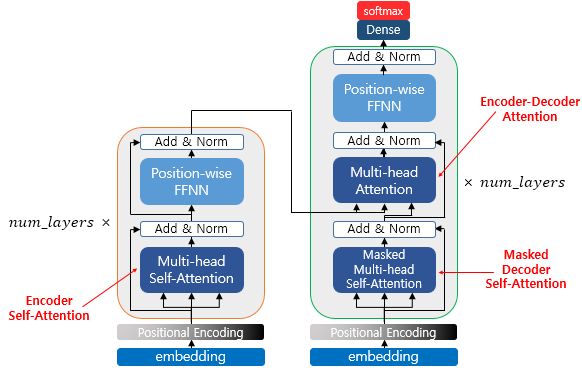

In [20]:
Image(img_path + '/8.png')

#### - 셀프 어텐션(Self-Attention)이란?

- 유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들인 경우
- 즉 인코더에서는 인코더 내 단어들끼리, 디코더에서는 디코더 내 단어들끼리 유사도를 구하는 것이다.
- 반면 인코더-디코더 어텐션은 서로 다른 단어 목록의 유사도를 구하므로 셀프 어텐션이 아니다.

<br>

- 예를 들어 아래 그림에서 'it'이 의미하는 것이 animal인지 street인지를 알기 위해 유사도를 구할 수 있다.
- 이를 통해 it이 animal과 연관되었을 확률이 높다는 것을 알아내는 것이다.

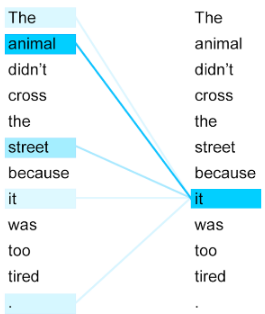

In [21]:
Image(img_path + '/9.png')

#### - 유사도를 구하는 방법 = Scaled Dot Product Attention

- 트랜스포머에서 어텐션 값을 구하는 방법은 다음과 같다.
$$Attention(Q, K, V) = softmax\left ( \frac{QK^T}{\sqrt{d_k}} \right )V$$
- $Q, K, V$는 각각 쿼리, key, value를 나타내며, 각각은 단어 벡터를 행으로 하는 문장 행렬이다.
- 벡터의 내적은 벡터의 유사도를 의미한다.
- 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링을 위한 것이다.
- $Q, K^T$ 행렬의 곱셈을 그림으로 표현하면 다음과 같다.

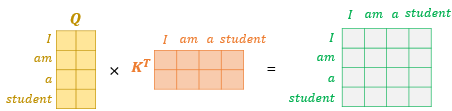

In [22]:
Image(img_path + '/10.png')

- 위 그림과 같은 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나누고, 또 0과 1 사이 값으로 Normalize하기 위해 소프트맥스 함수를 사용한다.
- 이렇게 구한 Q와 K의 유사도를 문장 행렬 V와 곱해서 어텐션 value를 얻을 수 있다.

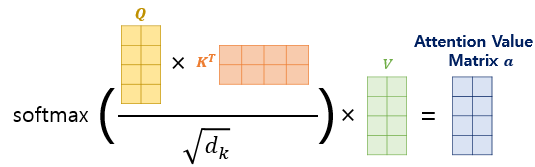

In [23]:
Image(img_path + '/11.png')

In [9]:
# scaled dot product attention 함수 구현하기
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)
        
    # softmax 적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 내적
    output = tf.matmul(attention_weights, value)
    return output

#### - 병렬로 어텐션 수행하기

- 트랜스포머에서 num_heads라는 변수는 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터이다.
- d_model은 임베딩 벡터의 차원.
- 즉 트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이를 행으로, d_model을 열의 크기로 가진다.
- 트랜스포머는 이 문장 행렬을 num_heads의 수만큼 쪼개서 어텐션을 수행하고, 이렇게 얻은 num_heads의 개수만큼 어텐션 값 행렬을 다시 하나로 concatenate한다.
- 아래 그림은 num_heads가 8개인 경우이다.

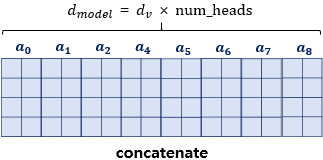

In [25]:
Image(img_path + '/12.png')

#### - 멀티-헤드 어텐션

- 아래 그림은 num_heads가 8일 때, 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 있음을 보여준다.
- 즉 8개의 머리는 각각 다른 관점에서 어텐션을 수행하는 것이다.
- 예를 들어 it_이라는 토큰이 animal_과 유사하다고 보는 관점과 street_과 유사하다고 보는 관점이 한꺼번에 모두 표현 가능하게 된다.

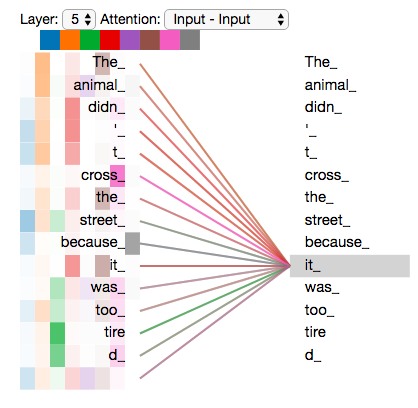

In [26]:
Image(img_path + '/13.png')

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)
        
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

## 3. 마스킹 Masking

- 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법
- 트랜스포머에서는 어텐션을 위해 크게 두 가지 마스킹을 사용한다.

#### 1) 패딩 마스킹(Padding Masking)

- 패딩 토큰을 이용
- 패딩을 위한 숫자 0은 실제로는 의미가 없으므로 어텐션 등과 같은 연산 시에는 제외해줘야 한다.
- 패딩 마스킹은 숫자가 0인 위치에서만 숫자 1을, 0이 아닌 위치에서는 숫자 0인 벡터를 출력한다.

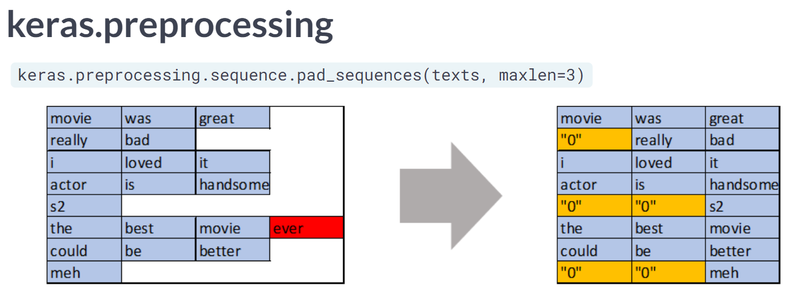

In [28]:
Image(img_path + '/14.png')

In [11]:
# 패딩 마스킹 구현
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [30]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


#### 2) 룩 어헤드 마스킹(Look-ahead Masking) = 다음 단어 가리기

- RNN은 step이라는 개념이 존재해서 각 step마다 단어가 순서대로 입력으로 들어가는 반면, 트랜스포머는 문장 행렬을 만들어 한 번에 행렬 형태로 입력이 들어간다.
- 이 때문에 추가적인 마스킹이 필요하다.
- RNN은 구조상 다음 단어를 만들기 위해, 자신보다 앞에 있는 단어들만 참고한다.
- 하지만 트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있다.
- 그러나 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 것이므로, 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법을 쓰는 것이다.

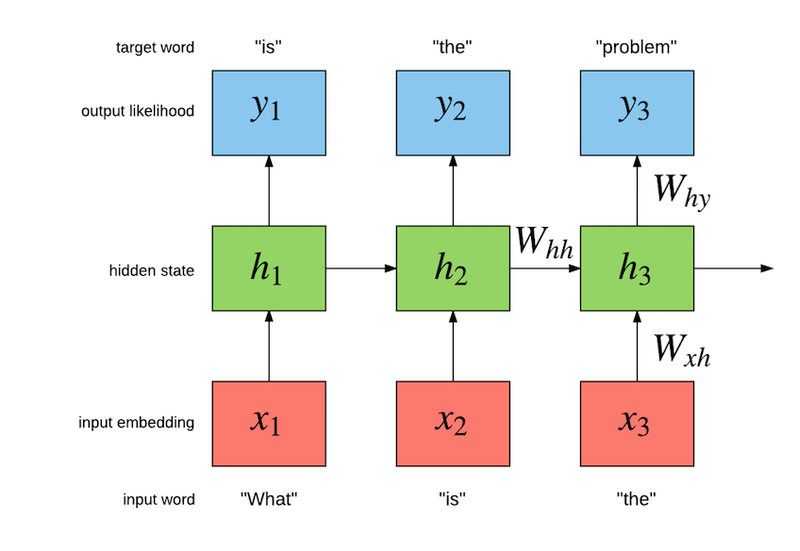

In [4]:
# RNN 구조
Image(img_path + '/15.png')

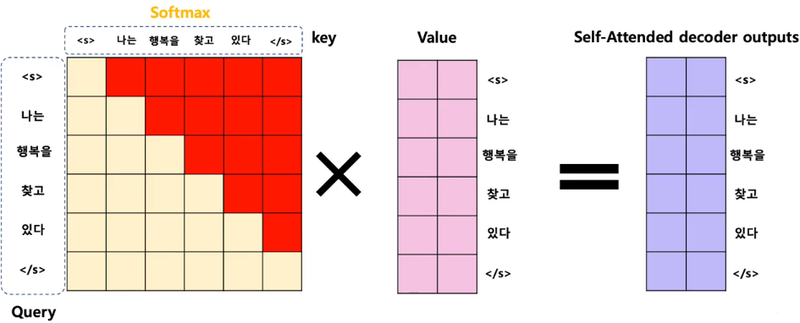

In [5]:
# 트랜스포머 구조
Image(img_path + '/16.png')

- 위 그림에서 빨간색으로 색칠된 부분이 마스킹을 의미한다.
- 어텐션 연산 시 현재 단어를 기준으로 이전 단어들과의 유사도만 구하도록 한다.

In [6]:
# 룩어헤드 마스킹 구현
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [12]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


- 위 출력 결과에서 대각선 형태로 숫자 1이 채워지는 것을 볼 수 있다.
- 그러나 룩어헤드 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약 숫자 0인 단어가 있다면 이 또한 패딩해야 한다.
- 때문에 create_look_ahead() 함수는 내부적으로 padding_mask 함수도 호출한다.

In [13]:
# 숫자 0이 포함된 경우 테스트
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 4. 트랜스포머의 인코더

- 하나의 인코더 layer는 크게 2개의 sub layer로 나뉜다.
    - 1) 셀프 어텐션(Self Attention)
    - 2) 피드 포워드 신경망(Feed Forward Neural Network)
- 멀티 헤드 어텐션으로 병렬적으로 이루어진다.

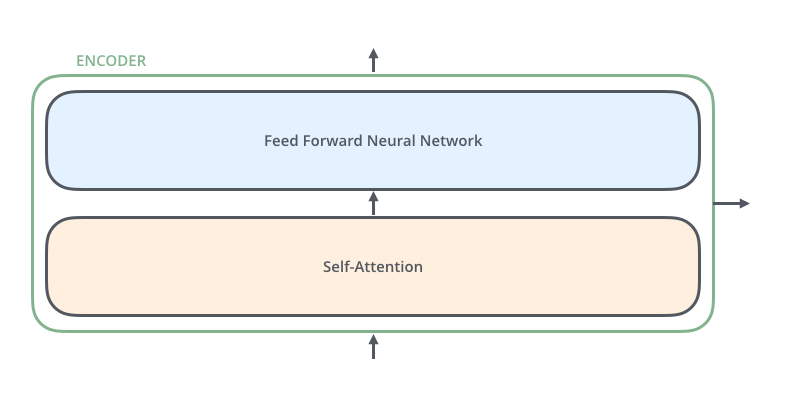

In [14]:
Image(img_path + '/17.png')

In [51]:
# 인코더 레이어 구현
# 그 안에 두 개의 서브 레이어가 있음
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask})
    
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

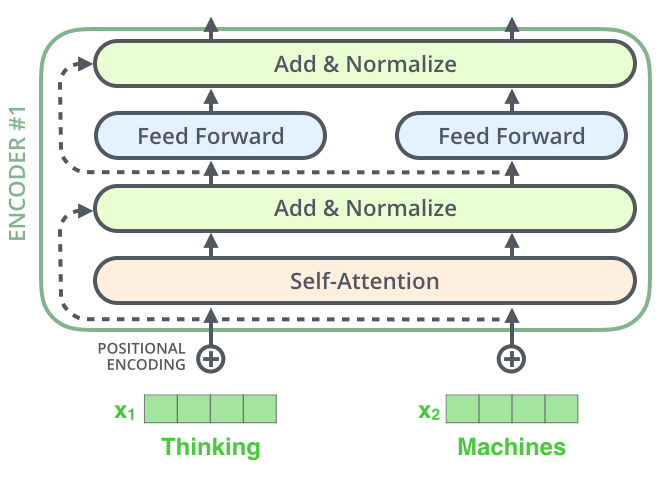

In [16]:
Image(img_path + '/18.png')

#### - 인코더 레이어를 쌓아 인코더 만들기

- 위에서 구현한 인코더 레이어를 임베딩 레이어, 포지셔널 인코딩과 연결한다.
- 이때 인코더 레이어의 개수는 num_layers라는 하이퍼파라미터로 조정이 가능하다.

In [49]:
# 전체 인코더 연결해서 구현하기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout=dropout,
                                name="encoder_layer_{}".format(i),)([outputs, padding_mask])
        
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 5. 트랜스포머의 디코더

- 디코더는 3개의 서브 레이어로 구성된다.
    - 1) 셀프 어텐션
    - 2) 인코더-디코더 어텐션
    - 3) 피드 포워드 신경망
- 인코더-디코더 어텐션은 셀프 어텐션과는 달리, 쿼리가 디코더의 벡터인 반면에 key, value가 인코더의 벡터라는 특징이 있다.
- 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정이다.
- 디코더의 어텐션도 모두 scaled dot product attention을 멀티 헤드 어텐션으로 병렬 수행한다.

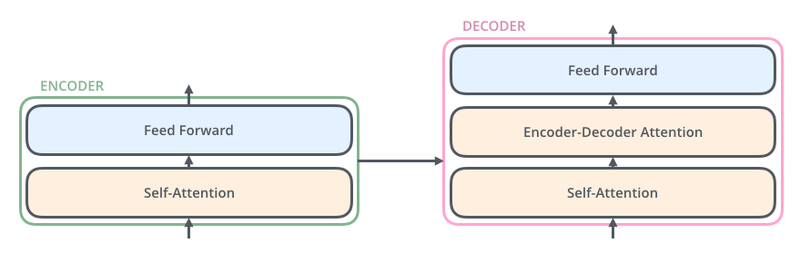

In [20]:
Image(img_path + '/19.png')

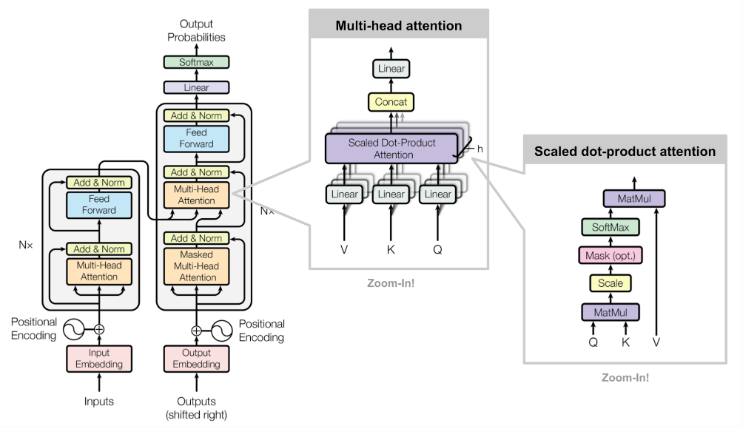

In [21]:
Image(img_path + '/20.png')

In [24]:
# 디코더 레이어 구현
# 그 안에 세 개의 서브 레이어가 있음
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask})

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask})

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs, name=name)

In [25]:
# 전체 디코더 구현
# 디코더 레이어를 임베딩 레이어, 포지셔널 인코딩과 연결
# num_layers 만큼 디코더 레이어 쌓기
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs, name=name)

<hr>

## 6. 병렬 데이터 로드

- [Cornell Movie-Dialogs Corpus 데이터셋](http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip) 이용
- 말하는 사람의 문장과 그에 응답하는 문장의 쌍으로 이루어짐
- 1) 5만 개의 질문과 답변 쌍을 추출
- 2) 문장에서 단어와 구두점 사이에 공백 추가
- 3) 알파벳과 !?,.과 같은 구두점을 제외하고 다른 특수 문자는 모두 제거

In [31]:
# 데이터 로드
path_to_zip = tf.keras.utils.get_file('cornell_movie_dialogs.zip',
                                     origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
                                     extract=True)

path_to_dataset = os.path.join(os.path.dirname(path_to_zip), 'cornell movie-dialogs corpus')

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset, 'movie_conversations.txt')

In [27]:
# 전체 데이터 중 5만 개만 가져온다
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [28]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    
    # 단어와 구두점 사이 거리를 만든다
    # 예를 들어서 "I am a student." => "I am a student ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [29]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]
        
    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

        for i in range(len(conversation) - 1):
            # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    
    return inputs, outputs

In [32]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 50000
전체 샘플 수 : 50000


In [33]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: she s not a . . .
전처리 후의 22번째 답변 샘플: lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


## 7. 병렬 데이터 전처리

- 질문과 답변을 각각 questions, answers에 저장한 것으로 전처리를 해본다.
- 1) Tensorflow Datasets SubwordTextEncoder를 토크나이저로 사용
    - 단어보다 더 작은 단위인 subword를 기준으로 토크나이징하고,
    - 각 토큰을 고유한 정수로 인코딩한다.
- 2) 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 토큰을 추가한다. START_TOKEN, END_TOKEN
- 3) 최대 길이 MAX_LENGTH인 40을 넘는 문장들은 필터링한다.
- 4) MAX_LEN보다 길이가 짤은 문장들은 40에 맞게 패딩한다.

### 1) 단어 사전 만들기

- tfds의 SubwordTextEncoder로 토크나이저를 정의하고 vocabulary를 생성

In [34]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [35]:
# 시작 및 종료 토큰도 단어 사전에 추가해 고유한 정수를 부여해준다
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [37]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8331]
END_TOKEN의 번호 : [8332]


In [38]:
# 시작 및 종료 토큰을 고려해 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8333


### 2) 단어 정수 인코딩 & 패딩

- tokenizer.encode()로 각 단어를 정수로 변환
- tokenizer.decode()는 정수 시퀀스를 단어 시퀀스로 변환함

In [39]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [60, 8, 37, 8172, 49]
정수 인코딩 후의 21번째 답변 샘플: [7824, 1223, 19, 61, 2, 4, 336, 10, 1595, 14, 1104, 698, 3263, 263, 16, 71, 14, 107, 2133, 900, 3, 59, 4, 23, 355, 204, 60, 8, 37, 885, 2289, 8107, 344, 1001, 5179, 4214, 342, 1]


In [40]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [42]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [43]:
questions, answers = tokenize_and_filter(questions, answers)

print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8333
필터링 후의 질문 샘플 개수: 44095
필터링 후의 답변 샘플 개수: 44095


### 3) 교사 강요(Teacher Forcing) 사용

- tf.data.Dataset API는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축한다.
- 이를 사용하기 위해 질문과 답변 쌍을 tf.data.Dataset의 입력으로 넣어준다.
- 이때 디코더의 입력과 실제 label 값을 정의하기 위해 교사 강요를 사용한다.
- 교사 강요란 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용한다.
- 훈련 시 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블, 즉 실제 알고 있는 정답을 t+1 시점의 입력으로 사용한다.
- 즉 한번 잘못 예측하면 뒤에서의 예측까지 영향을 주는 것을 방지함으로써 더 빠르고 효과적으로 훈련시키는 것이다.
- 교사 강요를 위해 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용한다.

In [44]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 모델 정의 및 학습

In [47]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    # 인코더
    enc_outputs = encoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[inputs, enc_padding_mask])
    
    # 디코더
    dec_outputs = decoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 1) 모델 생성
- num_layers, d_model, units는 하이퍼파라미터

In [52]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3187456     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 2) 손실함수

- 레이블인 시퀀스에 패딩이 되어 있으므로, loss 계산 시 패딩 마스크를 적용해야 한다.

In [53]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 3) 커스텀 학습률

- 커스텀 학습률 스케쥴링: 모델 학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법
- 이를 adam 옵티마이저에 적용한다.
- 수식으로 나타내면 다음과 같다.
$$lr = d_{model}^{-0.5}\, \cdot\, min(step\_num^{-0.5}, step\_num\, \cdot \, warmup\_steps^{-1.5})$$

In [55]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

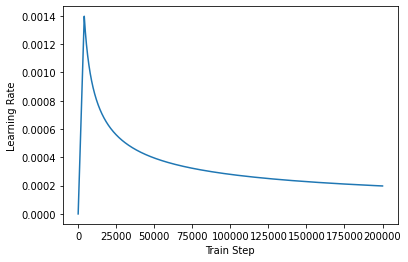

In [56]:
# 커스텀 학습률 스케쥴링 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 4) 모델 컴파일

In [58]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [59]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
689/689 [==============================] - 79s 104ms/step - loss: 2.5098 - accuracy: 0.0240
Epoch 2/20
689/689 [==============================] - 72s 104ms/step - loss: 1.5464 - accuracy: 0.0764
Epoch 3/20
689/689 [==============================] - 72s 105ms/step - loss: 1.4089 - accuracy: 0.0851
Epoch 4/20
689/689 [==============================] - 72s 105ms/step - loss: 1.3412 - accuracy: 0.0904
Epoch 5/20
689/689 [==============================] - 72s 105ms/step - loss: 1.2994 - accuracy: 0.0949
Epoch 6/20
689/689 [==============================] - 72s 105ms/step - loss: 1.2366 - accuracy: 0.0985
Epoch 7/20
689/689 [==============================] - 72s 105ms/step - loss: 1.1817 - accuracy: 0.1027
Epoch 8/20
689/689 [==============================] - 72s 105ms/step - loss: 1.1178 - accuracy: 0.1085
Epoch 9/20
689/689 [==============================] - 73s 105ms/step - loss: 1.0548 - accuracy: 0.1147
Epoch 10/20
689/689 [==============================] - 73s 105ms/step - l

## 7. 챗봇 테스트

- 예측(inference) 단계는 다음 과정을 거친다.
- 1) 새로운 입력 문장에 대해 훈련 때와 동일한 전처리를 거친다.
- 2) 입력 문장을 토크나이징하고, 시작 및 종료 토큰을 추가한다.
- 3) 패딩 & 룩어헤드 마스킹을 계산한다.
- 4) 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
- 5) 디코더는 예측된 다음 단어를 기존 입력 시퀀스에 추가해 새로운 입력으로 사용한다.
- 6) 종료 토큰이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [60]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
        
    return tf.squeeze(output_sequence, axis=0)

In [61]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [62]:
sentence_generation('Where have you been?')

입력 : Where have you been?
출력 : i m going to see them .


'i m going to see them .'

In [63]:
sentence_generation("It's a trap")

입력 : It's a trap
출력 : we re not going to hit the son of a bitch head on a body , and we re going to throw up .


'we re not going to hit the son of a bitch head on a body , and we re going to throw up .'